In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cnt
import colour as cs
from tqdm import tqdm

In [2]:
def planck(lam, T):
    fac = cnt.h*cnt.c/lam/cnt.k/T
    return 2*cnt.h*cnt.c**2/lam**5 / (np.exp(fac) - 1)

In [3]:
def n(lambd):
    return 1.3175 + 7.382e-9 / (lambd - 112.78e-9)

def s_opt(R, theta, phi, lambd):
    return 2.0 * R * (1.0 - np.cos(theta) + 2.0 * n(lambd) * np.cos(theta / 2.0 + phi / 4.0))

def inten(A, R, lambd, phi, thetas):
    k = 2.0 * np.pi / lambd
    integrand_cos = np.cos(k * s_opt(R, thetas, phi, lambd))
    integrand_sin = np.sin(k * s_opt(R, thetas, phi, lambd))

    int1 = np.trapz(integrand_cos, thetas)
    int2 = np.trapz(integrand_sin, thetas)

    return 0.5 * A**2 * R**2 * k**2 * (int1**2 + int2**2)

In [12]:
lambdas = np.arange(380.0e-9, 781.0e-9, 1.0e-9)
bbr_inten_distribution = planck(lambdas, 5000)
phis = np.linspace(np.deg2rad(38.5), np.deg2rad(44), 10000)
R = .5e-3
thetas = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 500)

In [13]:
spectral_angular_distrib = np.zeros((len(lambdas), len(phis)))
ASTMG173_sd = cs.plotting.SD_ASTMG173_ETR.copy()
for i, lamb in tqdm(enumerate(lambdas)):
    spectral_angular_distrib[i] = np.array([inten(ASTMG173_sd[int(lamb*1e9)], R, lamb, phi, thetas) for phi in phis])

401it [07:11,  1.08s/it]


In [10]:
colourspace = cs.RGB_COLOURSPACES['ITU-R BT.2020']
colors =[]

ASTMG173_sd = cs.plotting.SD_ASTMG173_ETR.copy()
rayleigh_sd = cs.phenomena.sd_rayleigh_scattering()
ASTMG173_sd.align(rayleigh_sd.shape)

background = rayleigh_sd * ASTMG173_sd
for i in range(0,spectral_angular_distrib.shape[1]):
    sd = cs.SpectralDistribution(spectral_angular_distrib[:, i], (lambdas * 1e9).astype(int))
    #sd = sd + background
    XYZ = cs.sd_to_XYZ(sd, k=683)
    colors.append(cs.XYZ_to_RGB(
        XYZ,
        colourspace.whitepoint,
        colourspace.whitepoint,
        colourspace.matrix_XYZ_to_RGB)
    )

C:\Users\hchr\anaconda3\envs\DataspellProjects\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "colour.XYZ_to_RGB" definition signature has changed with "Colour 0.4.3". The used call arguments are deprecated, please refer to the documentation for more information about the new signature.
  warn(*args, **kwargs)  # noqa: B028


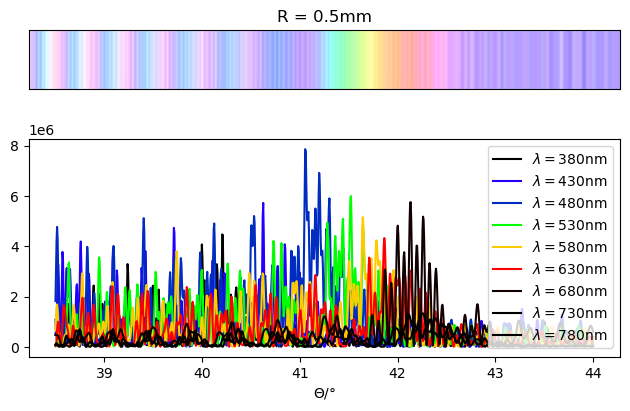

In [11]:
fig, ax = plt.subplots(2, sharex=False)
RGB = np.array(colors)
RGB = cs.cctf_encoding(RGB)

cmfs = cs.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]
#
ax[0].set(title=f"R = {R * 1e3}mm")
ax[0].set_xticks([])
ax[0].set_yticks([])
for i in range(0,spectral_angular_distrib.shape[0]):
    if(i % 50 == 0):
        c = cs.XYZ_to_RGB(cs.wavelength_to_XYZ(int(lambdas[i]*1e9)), colourspace.whitepoint,
                                               colourspace.whitepoint,
                                               colourspace.matrix_XYZ_to_RGB)
        c = np.clip(c, 0, 1)
        ax[1].plot(np.rad2deg(phis), spectral_angular_distrib[i, :], c=c, label = f"$\\lambda = {int(lambdas[i]*1e9)}$nm")
ax[1].legend()
ax[1].set(xlabel = "$\\Theta / °$")
cs.plotting.plot_multi_colour_swatches(
    [cs.plotting.ColourSwatch(RGB=c) for c in cs.algebra.normalise_maximum(RGB, axis=-1)],
    height=100,
    axes = ax[0]
);
fig.savefig("0_5")

In [116]:
def xyz_from_xy(x, y):
    return np.array((x, y, 1-x-y))

class ColourSystem:
    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('cie-cmf.txt', usecols=(1,2,3))
    def __init__(self, red, green, blue, white):
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        self.M = np.vstack((self.red, self.green, self.blue)).T
        self.MI = np.linalg.inv(self.M)
        self.wscale = self.MI.dot(self.white)
        self.T = self.MI / self.wscale[:, np.newaxis]

    def xyz_to_rgb(self, xyz, out_fmt=None):

        rgb = self.T.dot(xyz)
        if np.any(rgb < 0):
            w = - np.min(rgb)
            rgb += w
        if not np.all(rgb==0):
            rgb /= np.max(rgb)
        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    @staticmethod
    def rgb_to_hex(rgb):
        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        den = np.sum(XYZ)
        if den == 0.:
            return XYZ
        return XYZ / den

    def spec_to_rgb(self, spec, out_fmt=None):

        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)

illuminant_D65 = xyz_from_xy(0.3127, 0.3291)
cs_hdtv = ColourSystem(red=xyz_from_xy(0.67, 0.33),
                       green=xyz_from_xy(0.21, 0.71),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

cs_smpte = ColourSystem(red=xyz_from_xy(0.63, 0.34),
                        green=xyz_from_xy(0.31, 0.595),
                        blue=xyz_from_xy(0.155, 0.070),
                        white=illuminant_D65)

cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

1.4219999999999999